In [2]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set_style("ticks")

# Additional Imports
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load Data

In [3]:
# Load Data (only contains data on chocolate)
df = pd.read_csv("data/purchase_data.csv")
df.head(10)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
5,200000001,23,0,0,0,0,0,1.50,1.90,1.99,...,0,0,0,0,0,47,1,110866,1,0
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,0,0,0,0,0,47,1,110866,1,0
7,200000001,37,0,0,0,2,1,1.50,1.90,1.99,...,0,0,0,0,0,47,1,110866,1,0
8,200000001,41,0,0,0,0,0,1.35,1.58,1.97,...,1,0,0,0,0,47,1,110866,1,0
9,200000001,43,0,0,0,0,0,1.35,1.58,1.97,...,1,0,0,0,0,47,1,110866,1,0


# Load Models

In [4]:
scaler = pickle.load(open('models/scaler.pickle', 'rb'))
pca = pickle.load(open('models/pca.pickle', 'rb'))
km_pca = pickle.load(open('models/kmeans_pca.pickle', 'rb'))

# Scale, PCA and assign Clusters

In [5]:
features = df[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_features_std = scaler.transform(features)

In [6]:
df_pca = pca.transform(df_features_std)

In [7]:
km_segments = km_pca.predict(df_pca)

In [8]:
df_purchase_predictors = df.copy()
df_purchase_predictors['Segment'] = km_segments
df_purchase_predictors.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,47,1,110866,1,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,47,1,110866,1,0,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0


# Descriptive Analysis

In [9]:
cluster_names = {0:"Fewer-Opportunities", 1: "Standard", 2: "Well-off", 3: "Career-Focused"}

# Number of visits per ID
n_visits = df_purchase_predictors[['ID', 'Incidence']].groupby('ID').count()
n_visits.columns = ['n_visits']
n_visits.head()

# Number of purchases by ID
n_purchases = df_purchase_predictors[['ID', 'Incidence']].groupby('ID').sum()
n_purchases.columns = ['n_purchases']
n_purchases.head()

# Concatenate together
incidents = n_visits.join(n_purchases)
incidents['avg_n_purchases'] = incidents.n_purchases/incidents.n_visits
incidents = pd.merge(incidents, df_purchase_predictors[['Segment', 'ID']], left_on='ID', right_on='ID').set_index('ID')
incidents.head()

,n_visits,n_purchases,avg_n_purchases,Segment
ID,,,,
200000001,101,9,0.089109,0
200000001,101,9,0.089109,0
200000001,101,9,0.089109,0
200000001,101,9,0.089109,0
200000001,101,9,0.089109,0


In [27]:
segments_mean = incidents.groupby('Segment').mean()
segments_mean

,n_visits,n_purchases,avg_n_purchases
Segment,,,
0,116.085555,23.063503,0.200093
1,120.749072,25.595397,0.211581
2,139.610604,56.836009,0.322607
3,120.917355,37.224532,0.294998


In [15]:
segments_std = incidents.groupby('Segment').std()
segments_std

,n_visits,n_purchases,avg_n_purchases
Segment,,,
0,17.443591,14.035918,0.119450
1,20.177211,18.467960,0.129695
2,66.233728,81.900437,0.244095
3,20.504693,28.061560,0.180971


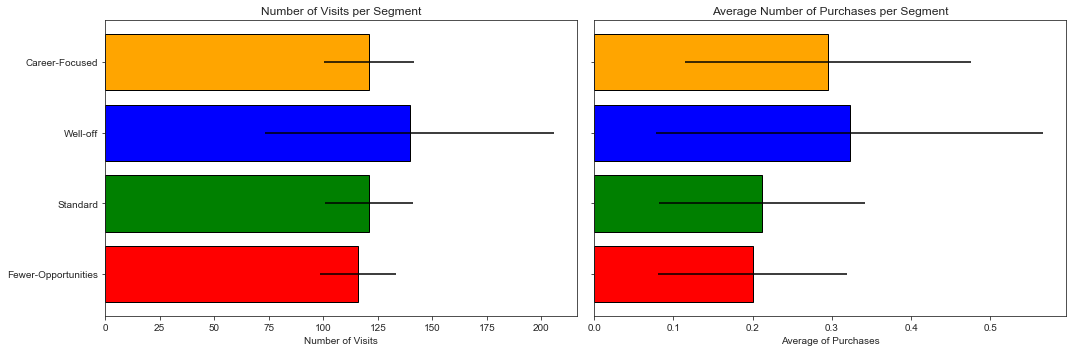

In [33]:
fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
axes[0].barh(data=segments_mean, y=(0,1,2,3), width='n_visits', ec='k', tick_label=cluster_names.values(), color=['r', 'g', 'b', 'orange'], xerr=segments_std['n_visits'])
axes[0].set_xlabel("Number of Visits")
axes[0].set_title("Number of Visits per Segment")

axes[1].barh(data=segments_mean, y=(0,1,2,3), width='avg_n_purchases', ec='k', tick_label=cluster_names.values(), color=['r', 'g', 'b', 'orange'], xerr=segments_std['avg_n_purchases'])
axes[1].set_xlabel("Average of Purchases")
axes[1].set_title("Average Number of Purchases per Segment")
plt.tight_layout()

# Brand Choice

In [34]:
df_purchases = df_purchase_predictors[df_purchase_predictors.Incidence == 1]

In [39]:
brand_dummies = pd.get_dummies(df_purchases['Brand'], prefix='brand', prefix_sep='_')
brand_dummies['Segment'], brand_dummies['ID'] = df_purchases['Segment'], df_purchases['ID']
brand_dummies

,brand_1,brand_2,brand_3,brand_4,brand_5,Segment,ID
6,0,1,0,0,0,0,200000001
11,0,0,0,0,1,0,200000001
19,1,0,0,0,0,0,200000001
24,0,0,0,1,0,0,200000001
29,0,1,0,0,0,0,200000001
...,...,...,...,...,...,...,...
58621,0,1,0,0,0,0,200000500
58648,1,0,0,0,0,0,200000500
58674,0,1,0,0,0,0,200000500
58687,0,1,0,0,0,0,200000500


In [42]:
# Average brand choice per customer
temp = brand_dummies.groupby('ID').mean()
temp

,brand_1,brand_2,brand_3,brand_4,brand_5,Segment
ID,,,,,,
200000001,0.111111,0.444444,0.000000,0.222222,0.222222,0
200000002,0.000000,0.090909,0.000000,0.909091,0.000000,3
200000003,0.000000,0.800000,0.000000,0.000000,0.200000,0
200000004,0.000000,0.090909,0.000000,0.000000,0.909091,0
200000005,0.000000,0.000000,0.000000,0.000000,1.000000,2
...,...,...,...,...,...,...
200000496,0.050000,0.700000,0.000000,0.050000,0.200000,1
200000497,0.023256,0.651163,0.000000,0.302326,0.023256,0
200000498,0.128205,0.589744,0.282051,0.000000,0.000000,1


In [133]:
# Average brand choice per segement
mean_brand_choice = temp.groupby('Segment').mean()
mean_brand_choice

2.29 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


([<matplotlib.axis.YTick at 0x1a2d72d790>,
 <a list of 4 Text yticklabel objects>)

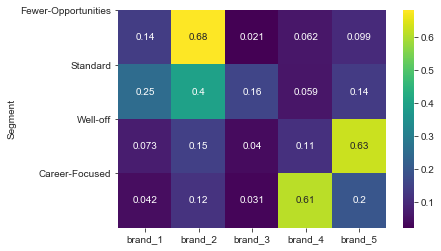

In [56]:
sns.heatmap(mean_brand_choice, annot=True, cmap='viridis')
plt.yticks([0,1,2,3], cluster_names.values(), rotation=0)

,brand_1,brand_2,brand_3,brand_4,brand_5,Segment
ID,,,,,,
200000001,0.111111,0.444444,0.000000,0.222222,0.222222,0
200000002,0.000000,0.090909,0.000000,0.909091,0.000000,3
200000003,0.000000,0.800000,0.000000,0.000000,0.200000,0
200000004,0.000000,0.090909,0.000000,0.000000,0.909091,0
200000005,0.000000,0.000000,0.000000,0.000000,1.000000,2
...,...,...,...,...,...,...
200000496,0.050000,0.700000,0.000000,0.050000,0.200000,1
200000497,0.023256,0.651163,0.000000,0.302326,0.023256,0
200000498,0.128205,0.589744,0.282051,0.000000,0.000000,1


In [146]:
seg_brand = df_purchases.groupby(['Segment', 'Brand'])['Incidence'].sum().unstack()
seg_brand

# 3x slower:
# pd.pivot_table(data=df_purchases, index='Segment', columns='Brand', values='Incidence', aggfunc=sum)

5.57 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0.5, 1.0, 'Brand Choice per Segment')

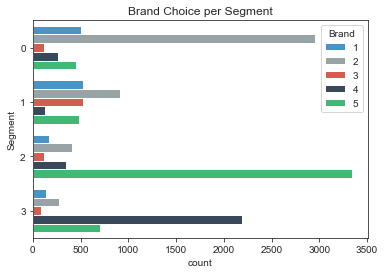

In [147]:
sns.countplot(orient='h', data=df_purchases, y='Segment', hue='Brand', palette=["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])
plt.title("Brand Choice per Segment")